## Install the twitter library in python

In [ ]:
INIT_INSTALL = False

if(INIT_INSTALL):
    !pip install --user tweepy
    !pip install --user simplejson
    !pip install --user textblob
    !python -m textblob.download_corpora lite
    !pip install nltk
    !pip install plotly
    !pip install pycountry-convert
    !pip install translate

# Streaming tweets and perform some data analysis


### Setting up and running a streaming crawler

In [83]:
# crawler libs
import tweepy
import simplejson as json
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
from textblob import TextBlob

# wordcloud dependencies
import nltk
import wordcloud
import matplotlib.pyplot as plt  
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, STOPWORDS

# general plotting and stats libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from scipy.stats import pearsonr

# geographical analysis lib 
import pycountry_convert as pc 
from googletrans import Translator

In [ ]:
#Complete with your keys 

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 

class MyListener(StreamListener):
    
    def __init__(self, api=None):
        super(StreamListener, self).__init__()
        self.num_tweets = 0

    def on_data(self, data):
        try:
            with open('crawled_tweets.json', 'a', newline='') as f:
                # Filtering data only with info about the country
                if json.loads(data).get('place'): #checks that the attribute exists 
                    # if json.loads(data)['place']['country'] == target: select specific country = target
                    f.write(data) # This will store the whole JSON data in the file, you can perform some JSON filters
                    twitter_text = json.loads(data)['text'] # You can also print your tweets here
                    self.num_tweets += 1
                
                # Just to limit the number of tweets collected to check the 
                # program at the beginning, then increase the limit
                if self.num_tweets < 200: 
                    return True
                else:
                    return False
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

 
    def on_error(self, status):
        print('Error :', status.place)
        return False
    
twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=["lgbt", "LGBT", "LGBTQ", "lgbtq", "lgbtq+", "LGBTQ+"]) # Add your keywords and other filters
#twitter_stream.filter(track=['Trump']) # Add your keywords and other
print('_______ End _______')

### Store the JSON data in a CSV for analysing

In [38]:
import simplejson as json

# Create the CSV file
with open ("data/LGBTQ_no_country.csv", 'w', encoding ='utf-8') as csv:
    # Write the title of the columns (features) that you want to store in the CSV file
    csv.write('id, created_at, followers, friends, favorite_count, verified, description, text \n')
    #country, followers, friends, text\n')
    
    # Copy the data from the JSON file
    with open('data/LGBTQ_no_country.json', 'r', encoding ='utf-8') as jsonfile:
        for tweet in jsonfile: 
            data = json.loads(tweet)
            text = str(data['text'].replace('\n', '').replace(",", "").replace('&','').replace('amp', '').replace('&amp;',''))
            id_ = str(data['id'])
            created_at = str(data['created_at'])
            #country = str(data['place']['country'])
            followers = str(data['user']['followers_count'])
            friends = str(data['user']['friends_count'])
            favorites = str(data['favorite_count'])
            verified = str(data['user']['verified'])
            description = ''
            if(data['user']['description']):
                description = str(data['user']['description'].replace('\n', '').replace(",", "").replace('amp', '').replace('&','').replace('&amp;',''))
            else: 
                description = ''
            line = id_+','+created_at+','+followers+','+friends+','+favorites+','+verified+','+description+','+text+'\n'
            #country+','+
            csv.write(line)

In [43]:
import simplejson as json

# Create the CSV file
with open ("data/crawled_tweets.csv", 'w', encoding ='utf-8') as csv:
    # Write the title of the columns (features) that you want to store in the CSV file
    csv.write('id, created_at, country, followers, friends, favorite_count, verified, description, text \n')
    #country, followers, friends, text\n')
    
    # Copy the data from the JSON file
    with open('data/crawled_tweets.json', 'r', encoding ='utf-8') as jsonfile:
        for tweet in jsonfile: 
            data = json.loads(tweet)
            text = str(data['text'].replace('\n', '').replace(",", "").replace('&','').replace('amp', '').replace('&amp;',''))
            id_ = str(data['id'])
            created_at = str(data['created_at'])
            country = str(data['place']['country'])
            followers = str(data['user']['followers_count'])
            friends = str(data['user']['friends_count'])
            favorites = str(data['favorite_count'])
            verified = str(data['user']['verified'])
            description = ''
            if(data['user']['description']):
                description = str(data['user']['description'].replace('\n', '').replace(",", "").replace('amp', '').replace('&','').replace('&amp;',''))
            else: 
                description = ''
            line = id_+','+created_at+','+country+','+followers+','+friends+','+favorites+','+verified+','+description+','+text+'\n'
            #country+','+
            csv.write(line)

### Load the previous CSV into pandas

In [2]:
import pandas as pd
tweets = pd.read_csv('data/LGBTQ_no_country.csv', index_col=0, encoding='utf-8', sep=r'\s*,\s*', engine='python')
tweets = tweets.dropna()
tweets.head(20)

,created_at,followers,friends,favorite_count,verified,description,text
id,,,,,,,
1218938315472195584,Sun Jan 19 16:48:35 +0000 2020,957.0,1561.0,0.0,False,Lesbian | Insignificant Neoconservative Ideolo...,Socialism benefits no one
1218938318135746562,Sun Jan 19 16:48:36 +0000 2020,14.0,131.0,0.0,False,🐶,@atahasnain53 Sir would you be willing to comm...
1218938324058103808,Sun Jan 19 16:48:37 +0000 2020,190.0,146.0,0.0,False,Just some bisexual idiot on the Internet. Slut...,@satiricole @AllianceLGB A transphobe was kick...
1218938330370519040,Sun Jan 19 16:48:39 +0000 2020,3829.0,4841.0,0.0,False,#Spoonie #NoStigma #NoH8 #LoveWins #RESIST #W...,RT @Jersey_Craig: The US Hasn't Only Stopped D...
1218938351337660421,Sun Jan 19 16:48:44 +0000 2020,296.0,403.0,0.0,False,Come Back Soon Woojin 🐻💙,RT @kpophappenings_: when that kpop boy played...
1218938356140331009,Sun Jan 19 16:48:45 +0000 2020,156.0,119.0,0.0,False,23. Professional nerd. Amateur musician. Quest...,idk who he is but we stan hard 😤😤😤😤😤😤😤😤😤😤😤😤😤😤
1218938357918715906,Sun Jan 19 16:48:45 +0000 2020,403.0,349.0,0.0,False,Je débarque dans ta vie en claquettes secondai...,@CharlotteThuil3 Mes mains sont lgbtq
1218938379548725249,Sun Jan 19 16:48:51 +0000 2020,243.0,1105.0,0.0,False,#BARON ; ☺️ i‘m the cutest babie alive,RT @kpophappenings_: when that kpop boy played...
1218938380983132162,Sun Jan 19 16:48:51 +0000 2020,981.0,969.0,0.0,False,rachel the anarchist. not a tolerant leftist. ...,she is just your version of gun girl. you t e ...


In [44]:
tweets_country = pd.read_csv('data/crawled_tweets.csv', index_col = 0, encoding = 'utf-8', sep = r'\s*,\s*', engine = 'python')
tweets_country = tweets_country.dropna()
tweets_country.head(20)

,created_at,country,followers,friends,favorite_count,verified,description,text
id,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brasil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brasil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...
1218196878824759296,Fri Jan 17 15:42:23 +0000 2020,France,1085,396,0,False,https://damocles.co/non-islamisation-france/si...,@Bugul_Noz @SignalZoorah @Neliak997755 @HughRo...
1218197171364925440,Fri Jan 17 15:43:33 +0000 2020,Panamá,315,222,0,False,No me vengan con mamadas 🌸🥰,Estas si las quiero para mi y mis cuecos 😭
1218197239866241027,Fri Jan 17 15:43:49 +0000 2020,United States,2904,354,0,False,the girl of your fever dreams,take a look at this dumbass cracker
1218197769199988736,Fri Jan 17 15:45:55 +0000 2020,France,257,276,0,False,📍#Paris 🇫🇷🇵🇹 I solemnly swear that I am up to ...,Connard de merde... Ou « Biggest Piece Of Shit...


### Analysing the polarity of the tweets

In [19]:
# Go through all tweets without country and calculate sentiment
for index in tweets.index: 
    # Retrieve tweet for index i.e. id
    tweet = tweets.loc[index, 'text']

    # Calculate sentiment
    blob = TextBlob(tweet)

    # Concatenate polarity and subj into dataframe sentiment (columns: index, polar, subj)
    tweets.loc[index, 'polar'] = blob.sentiment[0]
    tweets.loc[index, 'subj'] = blob.sentiment[1]

In [63]:
# Go through all tweets with country and calculate sentiment
for index in tweets_country.index: 
    # Retrieve tweet for index i.e. id
    tweet = tweets_country.loc[index, 'text']

    # Calculate sentiment
    blob = TextBlob(tweet)

    # Concatenate polarity and subj into dataframe sentiment (columns: index, polar, subj)
    tweets_country.loc[index, 'polar'] = blob.sentiment[0]
    tweets_country.loc[index, 'subj'] = blob.sentiment[1]

In [20]:
tweets.head()

,created_at,followers,friends,favorite_count,verified,description,text,polar,subj
id,,,,,,,,,
1218938315472195584,Sun Jan 19 16:48:35 +0000 2020,957.0,1561.0,0.0,False,Lesbian | Insignificant Neoconservative Ideolo...,Socialism benefits no one,0.000000,0.000000
1218938318135746562,Sun Jan 19 16:48:36 +0000 2020,14.0,131.0,0.0,False,🐶,@atahasnain53 Sir would you be willing to comm...,0.325000,0.725000
1218938324058103808,Sun Jan 19 16:48:37 +0000 2020,190.0,146.0,0.0,False,Just some bisexual idiot on the Internet. Slut...,@satiricole @AllianceLGB A transphobe was kick...,0.300000,0.350000
1218938330370519040,Sun Jan 19 16:48:39 +0000 2020,3829.0,4841.0,0.0,False,#Spoonie #NoStigma #NoH8 #LoveWins #RESIST #W...,RT @Jersey_Craig: The US Hasn't Only Stopped D...,0.000000,1.000000
1218938351337660421,Sun Jan 19 16:48:44 +0000 2020,296.0,403.0,0.0,False,Come Back Soon Woojin 🐻💙,RT @kpophappenings_: when that kpop boy played...,0.408333,0.641667


In [24]:
tweets['polar'].describe()

count    1825.000000
mean        0.109242
std         0.313517
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.400000
max         1.000000
Name: polar, dtype: float64

In [25]:
tweets['subj'].describe()

count    1825.000000
mean        0.421778
std         0.331061
min         0.000000
25%         0.000000
50%         0.500000
75%         0.641667
max         1.000000
Name: subj, dtype: float64

C:\Users\fabis\Anaconda3\envs\WI\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


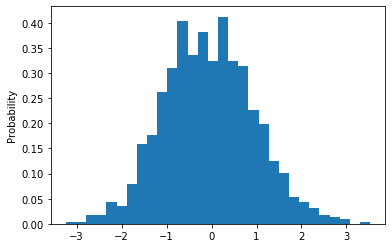

In [31]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=tweets['polar'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = tweets['polar'].max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10

Text(0.5, 0, 'Polarity [-1, 1]')

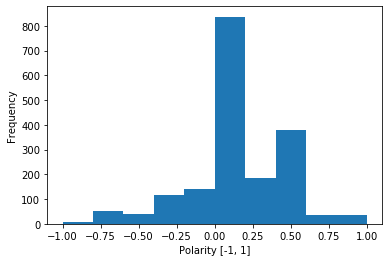

In [35]:
plt.hist(tweets['polar'])
plt.ylabel('Frequency')
plt.xlabel('Polarity [-1, 1]')

Text(0.5, 0, 'Subjectivity ([0, 1])')

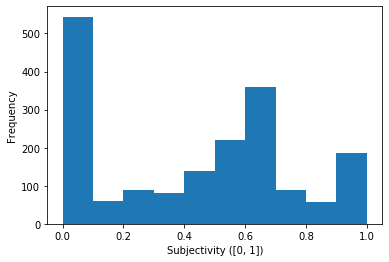

In [36]:
plt.hist(tweets['subj'])
plt.ylabel('Frequency')
plt.xlabel('Subjectivity ([0, 1])')

### Generating a wordcloud

In [11]:
def word_count(series):
    wordcount_dict = dict()
    for text in series:
        text = str(text)
        words = text.split()
        
        for word in words: 
            if word in wordcount_dict: 
                wordcount_dict[word] += 1
            else: 
                wordcount_dict[word] = 1 
    return wordcount_dict
            
    
#First, create the dictionary used to produce the genre wordcloud    
wordcount_dict = word_count(tweets['text'])

In [12]:
#words to remove from the counter
stop_words = stopwords.words('english')

additional_Stopwords = ['LGBT','#LGBT', 'LGBT','LGBTQ','#LGBTQ', 'LGBTQ+',
                        'lgbtq', 'lgbtq+','#lgbtq', 'lgbt', '#lgbt',
                        'de', 'se', 'la', 'I', 'The', 'RT' ]


for stopword in additional_Stopwords: 
    stop_words.append(stopword)   

In [13]:
def remove_words(word_dict, removal_list): 
    copy_dict = dict(word_dict)
    for word in removal_list: 
        copy_dict[word] = 0
    
    return copy_dict

wordcount_dict_clean = remove_words(wordcount_dict, stop_words)

In [14]:
#Second, create the wordcloud
# - create object "genre_wordcloud = WordCloud(...)"
# - generate word cloud from frequencies in "genres"
wordcloud = WordCloud(background_color="white")
wordcloud = wordcloud.generate_from_frequencies(wordcount_dict_clean)

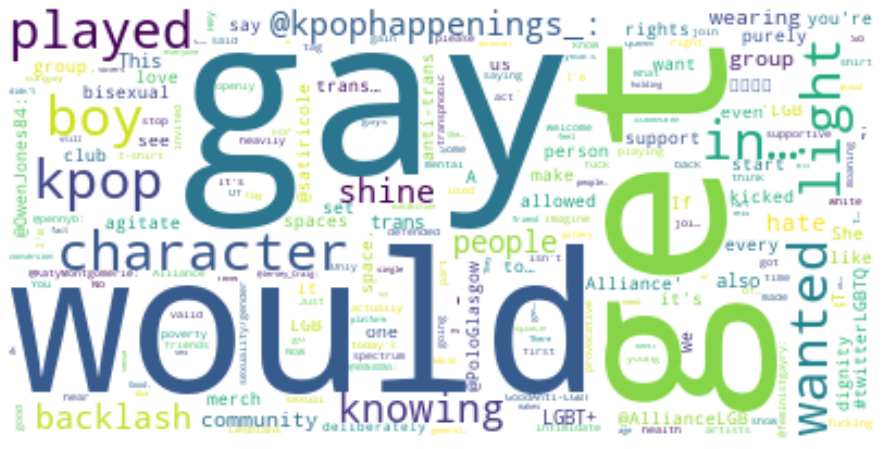

In [15]:
# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Geographical Analysis

In [46]:
translate_urls = ["translate.google.com", "translate.google.co.kr",
                      "translate.google.at", "translate.google.de",
                      "translate.google.ru", "translate.google.ch",
                      "translate.google.fr", "translate.google.es"]

# Translate 
translator = Translator(service_urls=translate_urls)   
tweets_country['trans_country'] = [translator.translate(orig_country).text for orig_country in tweets_country['country']]

In [54]:
for index in tweets_country.index: 
    single_country = tweets_country.loc[index, 'trans_country']
    try:
        country_iso_alpha_3 = pc.country_name_to_country_alpha3(single_country, cn_name_format="default")
        tweets_country.loc[index, 'iso_alpha_3'] = country_iso_alpha_3
    except KeyError as e:
        print('KeyError - reason {}'.format(str(e)))
        tweets_country.loc[index, 'iso_alpha_3'] = ''
    except IndexError as e:
        print('I got an IndexError - reason {}'.format(str(e)))
    except TypeError as e:
        tweets_country.loc[index, 'iso_alpha_3'] = ''
        print('I got an TypeError - reason {}'.format(str(e)))

KeyError - reason "Invalid Country Alpha-3 code: 'U.S'"
KeyError - reason "Invalid Country Alpha-3 code: 'U.S'"
KeyError - reason "Invalid Country Name: 'Holland'"
KeyError - reason "Invalid Country Alpha-3 code: 'U.S'"
KeyError - reason "Invalid Country Name: 'Republic of Korea'"
KeyError - reason "Invalid Country Alpha-3 code: 'U.S'"
KeyError - reason "Invalid Country Name: 'UK'"


In [53]:
# Map key error values based on dictionary
country_dic = {"Brasil": "Brazil", "Panamá": "Panama", "ประเทศไทย": "Thailand", "México": "Mexico", "Estados Unidos": "United States", "Schweiz": "Switzerland", "Deutschland": "Germany", "België": "Belgium", "Italia": "Italy", "Canadá": "Canadá", "Holanda": "Netherlands", "日本": "Japan", "Danmark": "Denmark", "Türkiye": "Turkey", "Republic of Korea": "South Korea", "Royaume-Uni": "United Kingdom"}

tweets_tratweets_country['country'].replace(country_dic)

id
1218195973513629696            Brazil
1218196070527897603            Brazil
1218196078035718146     United States
1218196163620413442    United Kingdom
1218196522283737089     United States
                            ...      
1219238918295519239    United Kingdom
1219238961387917312     United States
1219239514885054467    United Kingdom
1219239671303213057            France
1219240111864471556            France
Name: country, Length: 554, dtype: object

In [64]:
tweets_country.head()

,created_at,country,followers,friends,favorite_count,verified,description,text,trans_country,iso_alpha_3,polar,subj
id,,,,,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brasil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara,Brazil,BRA,0.000000,0.000000
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brasil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...,Brazil,BRA,0.000000,0.000000
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...,United States,USA,0.000000,0.000000
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...,United Kingdom,GBR,0.472917,0.645833
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...,United States,USA,0.433333,0.466667


In [66]:
# Plot polarity for country
fig = px.choropleth(tweets_country, 
                    locations="iso_alpha_3",
                    color="polar", # lifeExp is a column of gapminder
                    hover_name="trans_country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [68]:
# Plot subjectivity for country
fig = px.choropleth(tweets_country, 
                    locations="iso_alpha_3",
                    color="subj", # lifeExp is a column of gapminder
                    hover_name="trans_country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

### Impact of Followers and Favorites on Polarity and Subjectivity

Text(0, 0.5, '# Followers')

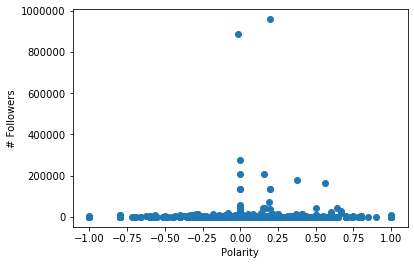

In [86]:
plt.scatter(tweets['polar'], tweets['followers'])
plt.xlabel('Polarity')
plt.ylabel('# Followers')

Text(0, 0.5, '# Followers')

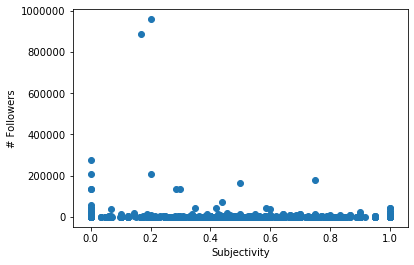

In [87]:
plt.scatter(tweets['subj'], tweets['followers'])
plt.xlabel('Subjectivity')
plt.ylabel('# Followers')

In [88]:
# calculate Pearson's correlation
corr_pol, _ = pearsonr(tweets['polar'], tweets['followers'])
print('Pearsons correlation between #followers and polarity: %.3f' % corr_pol)

corr_subj, _ = pearsonr(tweets['subj'], tweets['followers'])
print('Pearsons correlation between #followers and subjectivity: %.3f' % corr_subj)

Pearsons correlation between #followers and polarity: 0.003
Pearsons correlation between #followers and subjectivity: -0.041


Text(0, 0.5, '# Favorites')

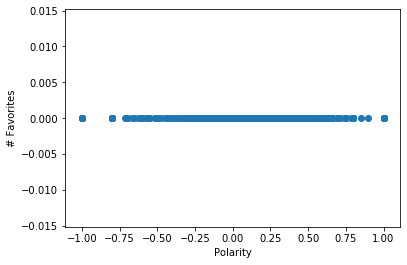

In [90]:
plt.scatter(tweets['polar'], tweets['favorite_count'])
plt.xlabel('Polarity')
plt.ylabel('# Favorites')